In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from glob import glob

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from keras.models import load_model
network = load_model('/content/drive/MyDrive/ChestVGG_SGD.h5')

In [5]:
network.layers[40].output

<KerasTensor: shape=(None, 7, 7, 1024) dtype=float32 (created by layer 'concatenate_11')>

In [6]:
from tensorflow.keras.layers import Input
model = Model(inputs=network.input, outputs=network.layers[40].output)

In [7]:
train_path = '/content/drive/MyDrive/Dataset/train'
test_path = '/content/drive/MyDrive/Dataset/test'

In [8]:
folders = glob('/content/drive/MyDrive/Dataset/train/*')
print(len(folders))

2


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255)

In [10]:
test_datagen = ImageDataGenerator(
    rescale=1./255)

In [11]:
train_set = train_datagen.flow_from_directory(train_path,
                                                target_size = (224, 224),
                                                batch_size=1,
                                                shuffle=False,
                                                 class_mode = 'categorical')

Found 4686 images belonging to 2 classes.


In [12]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            shuffle=False,
                                            batch_size=1,
                                            class_mode = 'categorical')

Found 1170 images belonging to 2 classes.


In [13]:
features=model.predict(train_set, steps=4686, verbose=1)

4686/4686 [==============================] - 383s 75ms/step


In [14]:
features_flattened=[]
for i in features:
  a=i.ravel()
  features_flattened.append(a)

In [15]:
from sklearn.svm import LinearSVC
svc=LinearSVC(C=1, dual=False, max_iter=6000)
model_svc=svc.fit(features_flattened, train_set.classes)

In [16]:
features_extracted_test=model.predict(test_set, steps=1170, verbose=1)

1170/1170 [==============================] - 88s 75ms/step


In [17]:
features_extracted_test_flattened=[]
for i in features_extracted_test:
  a=i.ravel()
  features_extracted_test_flattened.append(a)

In [18]:
preds_svc=model_svc.predict(features_extracted_test_flattened)

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_svc)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_svc)

[[304  12]
 [ 10 844]]


0.9811965811965812

In [20]:
from sklearn.ensemble import RandomForestClassifier
random_forest=RandomForestClassifier(random_state=0)
model_RF=random_forest.fit(features_flattened, train_set.classes)


In [21]:
preds_RF=model_RF.predict(features_extracted_test_flattened)

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_RF)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_RF)

[[297  19]
 [  8 846]]


0.9769230769230769

In [23]:
from sklearn.linear_model import LogisticRegression
logit=LogisticRegression(random_state=0, max_iter=6000)
model_logit=logit.fit(features_flattened, train_set.classes)


In [24]:
preds_logit=model_logit.predict(features_extracted_test_flattened)

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_logit)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_logit)

[[303  13]
 [ 10 844]]


0.9803418803418803

In [26]:
from sklearn.neighbors import KNeighborsClassifier
knn_optimized=KNeighborsClassifier(n_neighbors=5).fit(features_flattened, train_set.classes)

In [27]:
preds_knn=knn_optimized.predict(features_extracted_test_flattened)

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_knn)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_knn)

[[301  15]
 [ 10 844]]


0.9786324786324786

In [29]:
from sklearn.naive_bayes import GaussianNB
classifier_NB=GaussianNB()
model_NB=classifier_NB.fit(features_flattened, train_set.classes)

In [30]:
preds_NB=model_NB.predict(features_extracted_test_flattened)

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_test=test_set.classes
cf_matrix=confusion_matrix(y_test, preds_NB)
print(cf_matrix)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds_NB)

[[246  70]
 [ 18 836]]


0.9247863247863248

In [37]:
preds_CNN=[]
predictions=network.predict(test_set, steps=1170, verbose=1)
for i in range(len(predictions)):
    if predictions[i][0]>predictions[i][1]:
      preds_CNN.append(0)
    else:
      preds_CNN.append(1)

1170/1170 [==============================] - 98s 83ms/step


In [41]:
preds=[preds_CNN, preds_svc, preds_RF, preds_logit, preds_knn]

In [42]:
true_negative=0
false_negative=0
false_positive=0
true_positive=0
for i in range (len(test_set)):
  A=0
  B=0
  C=0
  D=0
  if y_test[i]==0:
    for pred in preds:
        if pred[i]==0:
          A+=1
        else:
          B+=1
    if A > B:
      true_negative+=1
    else: 
      false_positive+=1
  else:
    for pred in preds:
        if pred[i]==0:
          C+=1
        else:
          D+=1
    if C > D:
      false_negative+=1
    else: 
      true_positive+=1

In [43]:
print('TN:', true_negative)
print('FN:', false_negative)
print('TP:' ,true_positive)
print('FP:', false_positive)

TN: 303
FN: 8
TP: 846
FP: 13


[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

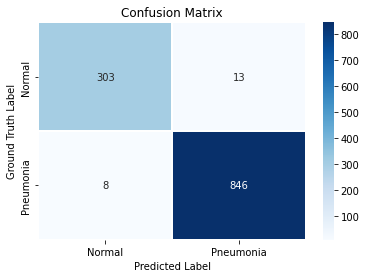

In [106]:
matrix=[[303,13],
        [8, 846]]

import seaborn as sns
import matplotlib.pyplot as plt
ax=plt.subplot()
sns.heatmap(matrix, cmap='Blues', annot=True, linewidths=1, fmt = 'd', ax=ax)
ax.set_xlabel('Predicted Label');ax.set_ylabel('Ground Truth Label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])